In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
import cv2
import torch
from torch.autograd import  Variable
from faster_rcnn.utils.images import imshow
from faster_rcnn.utils.cython_bbox import bbox_overlaps

from faster_rcnn.fastrcnn.bbox_transform import bbox_transform, bbox_transform_inv
import cPickle
from faster_rcnn.rpn_msr.proposal_target_layer import  ProposalTargetLayer
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from faster_rcnn.roi_pooling.modules.roi_pool import RoIPool
import gc
torch.backends.cudnn.enabled = False

In [3]:
with open('sorted_index', 'rb') as fp:
    sorted_index = cPickle.load(fp)

### Đọc dữ liệu từ MS COCO dataset


In [4]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.datasets.mscoco.dataset import CocoData
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer

dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'
batch_size = 5

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir, annFile = annFile)

data_gen = CocoGenerator(data=cap, sorted_index=sorted_index, batch_size=batch_size)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


loading annotations into memory...
Done (t=12.55s)
creating index...
index created!


INFO:faster_rcnn.utils.datasets.mscoco.dataset:need more than 0 values to unpack


Thử hiển thị ảnh cùng các bounding boxes

In [5]:
from faster_rcnn.faster_rcnn import RPN, FastRCNN


### Tính toán feed-forward


Chúng ta sử dụng một ảnh có kích thước đầu vào là  `(width , height) = (600, 800)`

Input:
    - im_data : 
        kích thước : (batch_size, dim, witdh, height)
    - ground_boxes: 
        kích thước (n, 4)
        

In [6]:
categories = ['__background__'] + [x['name'] for x in cap.coco.loadCats(cap.coco.getCatIds())]

In [7]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/anh/.torch/models/vgg16-397923af.pth
100.0%
/opt/conda/envs/pytorch/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
faster_rcnn/network.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.conv.weight)
faster_rcnn/network.py:54: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.fc.weight)


FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [8]:
param = filter(lambda x: x.requires_grad, net.parameters())
optimizer = SGD(param, lr=1e-3, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)
save_interval = 1000

In [9]:
def train(data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch):
    model.train()
    train_loss = 0
    cross_entropy = 0
    loss_box = 0
    rpn_loss = 0
    blobs = data_gen.next()
    max_height = np.max([blob['tensor'].shape[2] for blob in blobs])
    max_width = np.max([blob['tensor'].shape[3] for blob in blobs])
    batch_tensor = torch.Tensor(batch_size, 3, max_height, max_width).fill_(0.)
    total_boxes = 0
    batch_boxes = np.empty((0, 5))
    batch_boxes_index = np.empty((0,), dtype=np.int)
    im_info = np.array([[batch_tensor.shape[2], batch_tensor.shape[3]]])
    for i, blob in enumerate(blobs):
        shape = blob['tensor'].shape
        batch_tensor[i,:, :shape[2], :shape[3] ] = blob['tensor']
        total_boxes = blob['boxes'].shape[0]
        gt_classes =  blob['gt_classes']
        gt_boxes = np.hstack([blob['boxes'] , gt_classes[:, np.newaxis]])
        batch_boxes = np.vstack((batch_boxes, gt_boxes))
        a =  np.zeros((total_boxes , ), dtype=np.int)
        a.fill(i)
        batch_boxes_index = np.concatenate((batch_boxes_index, a), axis=0)
        
    imshow(batch_tensor[0], blobs[0]['boxes'])
    
    for step in range(1, steps_per_epoch +1):
        lr_scheduler.step()        
        try:
            cls_prob, bbox_pred, rois = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
        except Exception as e:
            print batch_boxes_index
            print e
            continue


        cls_data = cls_prob.data.cpu().numpy()
        max_class_idx = np.argmax(cls_data, axis=1)
        loss = model.loss
        cross_entropy += model.cross_entropy.item()
        loss_box += model.loss_box.item()
        train_loss += loss.item()
        rpn_loss += model.rpn.loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            log_text = 'step %d,  loss: %.4f' % (
                step, train_loss /(step))
            print(log_text)

            re_cnt = True


        if step % save_interval == 0:
            torch.save(model.state_dict(), 'faster_model_at_step_%s.pkl' % step)
    return blobs

In [10]:
# import sys
# for obj in gc.get_objects():
#     if torch.is_tensor(obj) and torch.is_tensor(obj.data):
#         print(type(obj), obj.size())

In [11]:
# blobs = train(t, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=1, steps_per_epoch=1500)
# torch.save(net.state_dict(), 'faster_model%s.pkl')

In [12]:
net.load_state_dict(torch.load('faster_model%s.pkl'))

In [13]:
blobs = t.next()
max_height = np.max([blob['tensor'].shape[2] for blob in blobs])
max_width = np.max([blob['tensor'].shape[3] for blob in blobs])
batch_tensor = torch.Tensor(batch_size, 3, max_height, max_width).fill_(0.)
total_boxes = 0
batch_boxes = np.empty((0, 5))
batch_boxes_index = np.empty((0,), dtype=np.int)
im_info = np.array([[batch_tensor.shape[2], batch_tensor.shape[3]]])
for i, blob in enumerate(blobs):
    shape = blob['tensor'].shape
    batch_tensor[i,:, :shape[2], :shape[3] ] = blob['tensor']
    total_boxes = blob['boxes'].shape[0]
    gt_classes =  blob['gt_classes']
    gt_boxes = np.hstack([blob['boxes'] , gt_classes[:, np.newaxis]])
    batch_boxes = np.vstack((batch_boxes, gt_boxes))
    a =  np.zeros((total_boxes , ), dtype=np.int)
    a.fill(i)
    batch_boxes_index = np.concatenate((batch_boxes_index, a), axis=0)


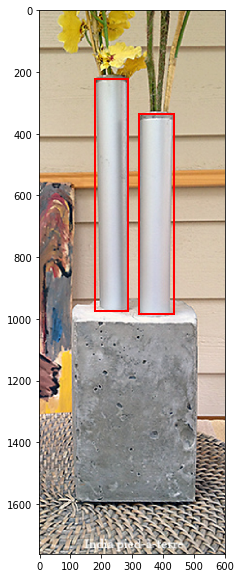

In [14]:
current_batch = 0
imshow(batch_tensor[current_batch], batch_boxes[[batch_boxes_index == current_batch]])


In [15]:
# net(batch_tensor, im_info, batch_boxes, batch_boxes_index)

In [24]:
net.detect("./test_im/harry-meghan-15.jpg")

DEBUG:root:[24275 25139 28847 25127 25991 24287 28835 20683  7451 24263]


(0, 4) (0,)


IndexError: too many indices for array

In [17]:
np.array([1,2])[np.newaxis, :].shape

(1, 2)

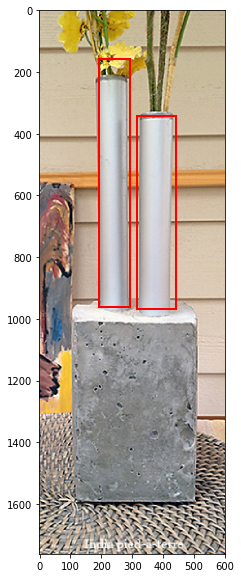

In [18]:
imshow(batch_tensor[current_batch], [[315.64458352, 340.88907238, 441.41098742, 969.25300711],
        [192.22088124, 158.83187526, 293.51993402, 962.7702144 ]])
